# Método do painel de fontes para corpos sem sustentação

- PET - Física
- Petiano: Gabriel Wendell Celestino Rocha
- Data: 25 de Maio de 2022

O objetivo deste Notebook é introduzir o *método do painel de fontes* para tratar de corpos que não tem sustentação aerodinâmica. Além disso, este Notebook serve como uma continuação do Notebook: [Vórtices potenciais e sustentação aerodinâmica](https://github.com/GabrielWendell/PET.py/blob/main/Notebooks/Vórtices%20potenciais%20e%20sustentação%20aerodinâmica.ipynb) [1] e faz parte da série de Notebooks escritos por mim relativos à Aerodinâmica Clássica Computacional.

Para uma melhor organização deste `Notebook` como um todo, este foi dividido em quatro seções:

1. **Método das imagens**;
2. **Folha de fonte**;
3. **Fluxo sobre um cilindro com painéis de fonte**;
4. **Método do painel de origem**.

## Pré-requisitos

Este `Notebook` faz parte da série de `Notebooks` relativos à *Dinâmica dos Fluídos e Aerodinâmica* escritos por mim. Em particular, faz parte da série que visa servir como uma breve introdução à Aerodinâmica Clássica Computacional. Dessa forma, é recomendável que o leitor tenha lido ao menos o `Notebook` [vórtices potenciais e sustentação aerodinâmica](https://github.com/GabrielWendell/PET.py/blob/main/Notebooks/Vórtices%20potenciais%20e%20sustentação%20aerodinâmica.ipynb) [1] (que por sua vez depende dos outros três `Notebooks` de Dinâmica dos Fluídos/Aerodinâmica anteriores) para facilitar a compreensão dos conceitos abordados neste `Notebook`.

### Importando as bibliotecas

A função `opt_plot()` é praticamente onipresente em todos os `Notebooks` que eu escrevo. Por isso, vamos defini-lá logo no ínicio junto com as bibliotecas necessárias.

In [2]:
import matplotlib.pyplot as plt
from scipy import integrate
import numpy as np
import os

%matplotlib notebook

def opt_plot():
    # plt.style.use('dark_background')
    plt.grid(True, linestyle=':', color='0.50')
    plt.minorticks_on()
    plt.tick_params(axis = 'both', which = 'minor', direction = "in",
                        top = True, right = True, length = 5, width = 1, labelsize = 15)
    plt.tick_params(axis = 'both', which = 'major', direction = "in",
                        top = True, right = True, length = 8, width = 1, labelsize = 15)

Curiosamente, na contramão dos outros `Notebooks`, para a realização deste em particular será necessário uma quantidade muito diminuta de bibliotecas que serão apenas as bibliotecas fundamentais necessárias para a realização de qualquer `Notebook`. Note que precisamos apenas do básico para trabalhar com Aerodinâmica Clássica.

#### Detalhes das bibliotecas:

In [2]:
%load_ext version_information
%version_information Matplotlib, Numpy, Scipy

Software versions
Python 3.9.8 64bit [MSC v.1929 64 bit (AMD64)]
IPython 8.0.1
OS Windows 10 10.0.19043
Matplotlib 3.5.1
Numpy 1.22.2
Scipy 1.8.0
Mon May 23 13:08:02 2022 Hora Padrão de Buenos Aires

Para instalar a magic extension `%version_information` do `IPython` usando o `pip`, execute a seguinte linha de comando em um terminal de sua preferência:

```
$ pip install version_information
```

Dado o exposto, vamos ao `Notebook` propriamente dito.

---

## 1. Método das imagens

Nos dois `Notebook` anteriores de Aerodinâmica, foi mostrado como as soluções fundamentais podem ser combinadas para porduzir padrões de linhas de fluxo que representam o fluxo em torno de objetos, por exemplo, um oval de Rankine e um cilindro circular (confira o `Notebook` [fontes, sumidouros e dipolos](https://github.com/GabrielWendell/PET.py/blob/main/Notebooks/Fontes%2C%20Sumidouros%20e%20Dipolos.ipynb) [2] para mais informações).

Você pode se perguntar agora: *podemos obter o fluxo em torno de uma parede reta?* A resposta é **sim**!

O método das imagens é simplesmente este: coloque uma singularidade perto de uma "parede" adicionando uma singularidade "imagem" do outro lado da parede. Às vezes, isso também é chamado de *interferências aerodinâmicas*.

Além disso, este `Notebook` servirá para introduzir a noção de **classes** em Python. Esta é uma maneira muito útil de organizar seu código, que se torna crucial à medida que os programas se tornam mais complexos.

Vamos começar logo definindo nossa grade computacional para facilitar nossa vida:

In [3]:
N = 50                               
x_start, x_end = -2.0, 2.0           
y_start, y_end = -1.0, 1.0            
x = np.linspace(x_start, x_end, N)    
y = np.linspace(y_start, y_end, N)    
X, Y = np.meshgrid(x, y)

### 1.1 Fonte perto de uma parede plana

Se uma fonte estiver localizada perto de uma parede, o padrão de fluxo será distorcido pela parede. Imagine uma fonte localizada em $y=y_{source}$ próximo a uma parede em $y=0$. A condição de contorno na parede requer que o escoamento seja tangente ali – para uma parede horizontal, $v=0$. O efeito da parede no fluxo da fonte é idêntico ao da colocação de outra fonte (uma imagem) de igual intensidade, localizada em $y=−y_{source}$.

Ok, agora é hora de jogar de forma inteligente e evitar a repetição de código que está desperdiçando nosso precioso tempo! Em um notebook anterior, já apresentamos a noção de função em Python, e agora vamos avançar com a criação de **classes**.

Uma classe é um pacote de dados (parâmetros e variáveis) e "métodos" ou funções que trabalham com esses dados. É uma maneira muito organizada de organizar o código. À medida que criamos códigos mais longos e complexos, isso nos ajuda a gerenciar a complexidade. O código torna-se mais fácil de manter, modificar e estender.

Vamos definir uma classe chamada `Source` que conterá informações relacionadas a uma fonte. Uma singularidade como uma fonte é definida por sua força e sua localização no domínio. Portanto, nossa classe Source terá três atributos definindo-a:

- `Strength`: a força da fonte;
- `x`: a localização da fonte no eixo $x$;
- `y`: a localização da fonte no eixo $y$.

O que gostaríamos de fazer após a definição de nossa fonte? Queremos calcular o campo de velocidade, bem como a função de fluxo. Assim, em nossa classe `Source`, temos que implementar dois métodos (funções incluídas em uma classe): um para calcular a velocidade (uma função chamada `velocity`) e outro para calcular a função stream (uma função chamada `stream_function`).

Vamos dar uma olhada detalhada dos métodos:

- método `velocity`: é uma função usada para calcular a velocidade na malha (`X`, `Y`) devido a uma fonte. Portanto, nosso método terá dois argumentos de entrada, `X` e `Y`, e retornará `u` e `v`, as componentes de velocidade da fonte.

- método `stream_function`: é uma função usada para calcular a função stream na malha (`X`, `Y`) devido a uma fonte. Portanto, nosso método terá dois argumentos de entrada, `X` e `Y`, e retornará `psi`, a função stream da fonte.

Além desses dois, toda classe precisa ter um *construtor*, que é simplesmente uma palavra chique para inicializar os dados. É uma função que é sempre chamada `__init__`:

In [4]:
class Source:
    """
    Contém informações relacionadas a uma fonte (ou coletor).
    """
    def __init__(self, strength, x, y):
        """
        Define a localização e a força da singularidade.
        
        Parâmetros
        ----------
        strength: float
            Força da singularidade.
        x: float
            Coordenada em x da singularidade.
        y: float
            Coordenada em y da singularidade.
        """
        self.strength = strength
        self.x, self.y = x, y
    
    def velocity(self, X, Y):
        """
        Computes the velocity field generated by the singularity.
        
        Parâmetros
        ----------
        X: 2D Numpy array de floats
            Coordenada em x dos pontos da malha.
        Y: 2D Numpy array de floats
            Coordenada em y dos pontos da malha.
        
        Retorna
        -------
        u: 2D Numpy array de floats
            Componente x do campo de velocidades gerado pela fonte.
        v: 2D Numpy array de floats
            Componente y do campo de velocidades gerado pela fonte.
        """
        u = (self.strength / (2 * np.pi) *
             (X - self.x) / ((X - self.x)**2 + (Y - self.y)**2))
        v = (self.strength / (2 * np.pi) *
             (Y - self.y) / ((X - self.x)**2 + (Y - self.y)**2))
        
        return u, v
    
    def stream_function(self, X, Y):
        """
        Calcula a função de fluxo gerada pela singularidade.
        
        Parâmetros
        ----------
        X: 2D Numpy array de floats
            Coordenada em x dos pontos da malha.
        Y: 2D Numpy array de floats
            Coordenada em y dos pontos da malha.
        
        Retorna
        -------
        psi: 2D Numpy array de floats
            Função de fluxo gerada pela fonte.
        """
        psi = (self.strength / (2 * np.pi) *
               np.arctan2((Y - self.y), (X - self.x)))
        
        return psi

O que é esse `self`? Quando chamamos a classe `Source`, ela se parecerá com uma chamada de função. 

```Python
    source = Source(1, 0, 0)
```

Isso nos permite criar uma fonte de força 1 localizada na origem. O Python chama automaticamente a função construtora com os parâmetros `(self, 1, 0, 0)`, ou seja, o Python adiciona `self` à lista de parâmetros, para significar "a fonte que precisa ser criada agora com os parâmetros a seguir".

Uma vez que criamos uma fonte, podemos chamar seus dois métodos para calcular o campo de velocidade e a função de fluxo na malha (`X`, `Y`). Assim como ao usar bibliotecas, indicaremos o método de uma classe usando a notação de ponto (como mostrado abaixo).

As componentes cartesianas da velocidade são dadas por:

$$u = \frac{\sigma}{2\pi}\frac{x-x_\text{source}}{\left(x-x_\text{source}\right)^2+\left(y-y_\text{source}\right)^2}$$

$$u = \frac{\sigma}{2\pi}\frac{y-y_\text{source}}{\left(x-x_\text{source}\right)^2+\left(y-y_\text{source}\right)^2}$$

e a função de fluxo é definida como:

$$\psi = \frac{\sigma}{2\pi}\cdot\arctan\left(\frac{y-y_\text{source}}{x-x_\text{source}}\right)$$

Agora, vamos ver como isso funciona.

In [5]:
strength_source = 1.0                          
x_source, y_source = 0.0, 0.5          

# Criação da fonte (objeto da classe Source) 
source = Source(strength_source, x_source, y_source)

# Calcule o campo de velocidade e a função de fluxo na grade de malha
u1, v1 = source.velocity(X, Y)
psi1 = source.stream_function(X, Y)

Notou a notação de ponto? Com o ponto, estamos dizendo: "pegue a função `velocity` do objeto `Source` que acabamos de criar e execute-a". Veja bem, a função de velocidade está associada aos dados da fonte em particular, porque faz parte de uma classe.

A imagem da fonte também será criada usando a classe `Source`, com a mesma força mas localização diferente. Você provavelmente começa a ver a eficiência de ter criado uma classe.

In [6]:
source_image = Source(strength_source, x_source, -y_source)
u2, v2 = source_image.velocity(X, Y)
psi2 = source_image.stream_function(X, Y)

Usando a superposição, podemos calcular as linhas de corrente de uma fonte nas proximidades de uma parede. A sobreposição das duas fontes leva ao seguinte campo de velocidade:

$$u = \frac{\sigma}{2\pi} \left[ \frac{x-x_\text{fonte}}{\left(x-x_\text{fonte}\right)^2+\left(y-y_\text{fonte}\right)^2} + \frac{x-x_\text{fonte}}{\left(x-x_\text{fonte}\right)^2+\left(y+y_\text{fonte}\right)^2} \right]$$

$$v = \frac{\sigma}{2\pi} \left[ \frac{y-y_\text{fonte}}{\left(x-x_\text{fonte}\right)^2+\left(y-y_\text{fonte}\right)^2} + \frac{y+y_\text{fonte}}{\left(x-x_\text{fonte}\right)^2+\left(y+y_\text{fonte}\right)^2} \right]$$

e a seguinte função de fluxo:

$$\psi = \frac{\sigma}{2\pi} \left[ \arctan\left(\frac{y-y_\text{fonte}}{x-x_\text{fonte}}\right) + \arctan\left(\frac{y+y_\text{fonte}}{x-x_\text{fonte}}\right) \right]$$

Agora fazemos a superposição da fonte e da sua imagem:

In [7]:
u = u1 + u2
v = v1 + v2
psi = psi1 + psi2

Por fim, vamos ao plot:

<IPython.core.display.Javascript object>


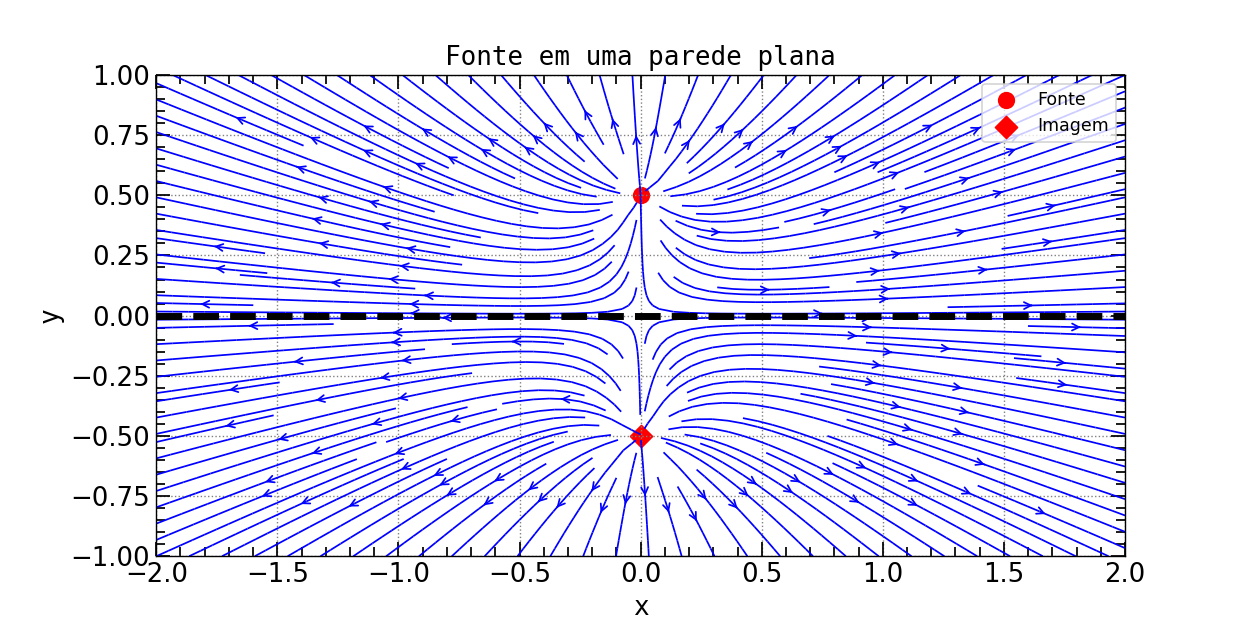

In [8]:
width = 10
height = (y_end - y_start) / (x_end - x_start) * width

plt.figure(figsize = (width, height))

plt.streamplot(X, Y, u, v, density = 2, color = 'blue', linewidth = 1, arrowsize = 1, arrowstyle = '->')
plt.scatter(source.x, source.y, color = 'red', s = 80, marker = 'o', label = r'Fonte')
plt.scatter(source_image.x, source_image.y, color = 'red', s = 80, marker = 'D', label = 'Imagem')
plt.axhline(0., color = 'black', linestyle = '--', linewidth = 4)

plt.title('Fonte em uma parede plana', family = 'monospace', fontsize = 15)
plt.xlabel('x', family = 'monospace', fontsize = 15)
plt.ylabel('y', family = 'monospace', fontsize = 15)
plt.xlim(x_start, x_end)
plt.ylim(y_start, y_end)

plt.legend(loc = 'best')
opt_plot()

plt.savefig('Fonte + parede plana.png', dpi = 400)

### 1.2 Vórtice perto de uma parede plana

De maneira semelhante, escrevemos outra classe chamada `Vortex`, exigindo como dados sua força e localização. A aula terá dois métodos: um para calcular a velocidade do vórtice e outro para calcular a função fluxo.

Mas também sempre precisamos de um construtor, uma função chamada `__init__`, para inicializar os dados de um vórtice:

In [9]:
class Vortex:
    """
    Contém informações relacionadas a um vórtice.
    """
    def __init__(self, strength, x, y):
        """
        Define a localização e a força do vórtice.
        
        Parâmetros
        ----------
        strength: float
            Força do vórtice.
        x: float
            Coordenada x do vórtice.
        y: float
            Coordenada y do vórtice.
        """
        self.strength = strength
        self.x, self.y = x, y
        
    def velocity(self, X, Y):
        """
        Calcula o campo de velocidade gerado por um vórtice.
        
        Parâmetros
        ----------
        X: 2D Numpy array de floats
            x-coordinate of the mesh points.
        Y: 2D Numpy array de floats
            y-coordinate of the mesh points.
        
        Retorna
        -------
        u: 2D Numpy array de floats
            Componente x do campo de velocidade gerado pelo vórtice.
        v: 2D Numpy array de floats
            Componente y do campo de velocidade gerado pelo vórtice.
        """
        u = (+self.strength / (2 * np.pi) *
             (Y - self.y) / ((X - self.x)**2 + (Y - self.y)**2))
        v = (-self.strength / (2 * np.pi) *
             (X - self.x) / ((X - self.x)**2 + (Y - self.y)**2))
        
        return u, v
        
    def stream_function(self, X, Y):
        """
        Calcula a função de fluxo gerada por um vórtice.
        
        Parâmetros
        ----------
        X: 2D Numpy array de floats
            Coordenada x dos pontos da malha.
        Y: 2D Numpy array de floats
            Coordenada y dos pontos da malha.
        
        Retorna
        -------
        psi: 2D Numpy array de floats
            Streamfunction gerada pelo vórtice.
        """
        psi = (-self.strength / (4 * np.pi) *
               np.log((X - self.x)**2 + (Y - self.y)**2))
        
        return psi

Agora é muito rápido criar dois objetos do tipo `Vortex` para um novo vórtice e sua imagem.

In [10]:
strength_vortex = 1.0                  
x_vortex, y_vortex = 0.0, 0.5          

# Cria um vórtice e calcula a velocidade e a função de fluxo
vortex = Vortex(strength_vortex, x_vortex, y_vortex)
u1, v1 = vortex.velocity(X, Y)
psi1 = vortex.stream_function(X, Y)

# Cria a imagem do vórtice e calcula a velocidade e a função de fluxo
vortex_image = Vortex(-strength_vortex, x_vortex, -y_vortex)
u2, v2 = vortex_image.velocity(X, Y)
psi2 = vortex_image.stream_function(X, Y)

Aplicando o princípio da superposição, podemos obter as linhas de corrente que representam um vórtice próximo a uma parede.

In [11]:
u = u1 + u2
v = v1 + v2
psi = psi1 + psi2

Geramos então o plot

<IPython.core.display.Javascript object>


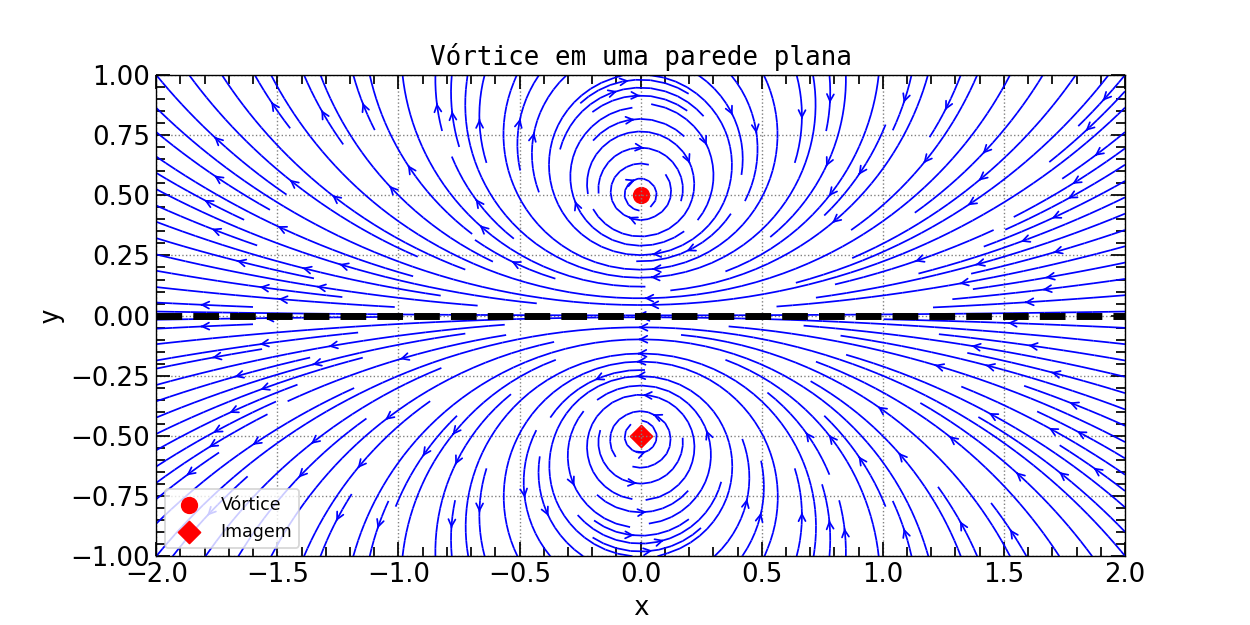

In [12]:
width = 10
height = (y_end - y_start) / (x_end - x_start) * width

plt.figure(figsize = (width, height))

plt.streamplot(X, Y, u, v, density = 2, color = 'blue', linewidth = 1, arrowsize = 1, arrowstyle = '->')
plt.scatter(vortex.x, vortex.y, color = 'red', s = 80, marker = 'o', label = r'Vórtice')
plt.scatter(vortex_image.x, vortex_image.y, color = 'red', s = 80, marker = 'D', label = r'Imagem')
plt.axhline(0., color = 'black', linestyle = '--', linewidth = 4)

plt.title('Vórtice em uma parede plana', family = 'monospace', fontsize = 15)
plt.xlabel('x', family = 'monospace', fontsize = 15)
plt.ylabel('y', family = 'monospace', fontsize = 15)
plt.xlim(x_start, x_end)
plt.ylim(y_start, y_end)

plt.legend(loc = 'best')
opt_plot()

plt.savefig('Vórtice + parede plana.png', dpi = 400)

### 1.3 Movimento de um par de vórtices perto do solo

Estamos nos divertindo demais. Vamos obter mais singularidades perto de uma parede. Dois vórtices vão te deixar tonto...

In [13]:
strength_vortex = 1.0                  
x_vortex1, y_vortex1 = -0.1, 0.5       
x_vortex2, y_vortex2 = +0.1, 0.5       

# Cria dois vórtices em posições diferentes
vortex1 = Vortex(+strength_vortex, x_vortex1, y_vortex1)
vortex2 = Vortex(-strength_vortex, x_vortex2, y_vortex2)

# Calcule a velocidade e a função de fluxo para cada vórtice
u1, v1 = vortex1.velocity(X, Y)
psi1 = vortex1.stream_function(X, Y)
u2, v2 = vortex2.velocity(X, Y)
psi2 = vortex2.stream_function(X, Y)

# Cria uma imagem para cada vórtice
vortex1_image = Vortex(-strength_vortex, x_vortex1, -y_vortex1)
vortex2_image = Vortex(+strength_vortex, x_vortex2, -y_vortex2)

# Calcula a velocidade e a função de fluxo de cada imagem
u3, v3 = vortex1_image.velocity(X, Y)
psi3 = vortex1_image.stream_function(X, Y)
u4, v4 = vortex2_image.velocity(X, Y)
psi4 = vortex2_image.stream_function(X, Y)

Aplicamos a superposição do par de vórtices e sua imagem

In [14]:
u = u1 + u2 + u3 + u4
v = v1 + v2 + v3 + v4
psi = psi1 + psi2 + psi3 + psi4

Por fim vamos ao plot...

<IPython.core.display.Javascript object>


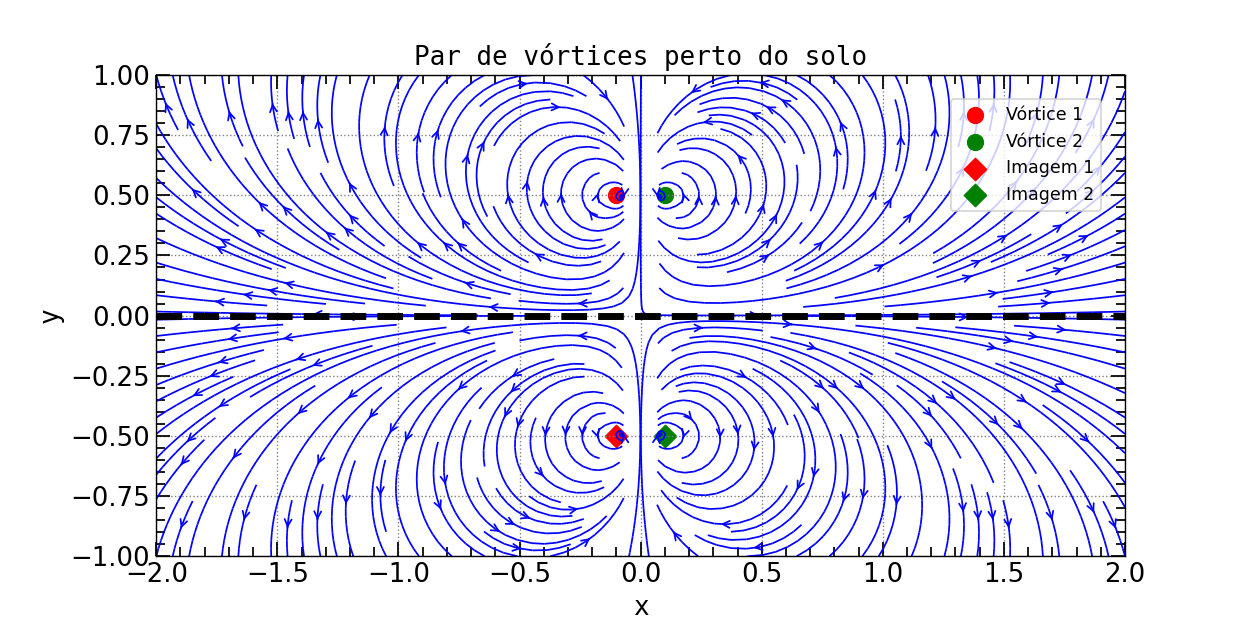

In [15]:
width = 10
height = (y_end - y_start) / (x_end - x_start) * width

plt.figure(figsize = (width, height))

plt.streamplot(X, Y, u, v, color = 'blue', density = 2, linewidth = 1, arrowsize = 1, arrowstyle = '->')
plt.scatter(vortex1.x, vortex1.y, color = 'red', s = 80, marker = 'o', label = r'Vórtice 1')
plt.scatter(vortex2.x, vortex2.y, color = 'green', s=80, marker = 'o', label = r'Vórtice 2')
plt.scatter(vortex1_image.x, vortex1_image.y, color = 'red', s = 80, marker = 'D', label = r'Imagem 1')
plt.scatter(vortex2_image.x, vortex2_image.y, color = 'green', s = 80, marker = 'D', label = r'Imagem 2')
plt.axhline(0.0, color = 'black', linestyle = '--', linewidth = 4)

plt.title('Par de vórtices perto do solo', family = 'monospace', fontsize = 15)
plt.xlabel('x', family = 'monospace', fontsize = 15)
plt.ylabel('y', family = 'monospace', fontsize = 15)
plt.xlim(x_start, x_end)
plt.ylim(y_start, y_end)

plt.legend(bbox_to_anchor = (0.82, 0.95), loc = 'upper left', borderaxespad = 0.)
opt_plot()

plt.savefig('Par de vórtice + solo.png', dpi = 400)

### 1.4 Dipolo perto de uma parede plana paralela a um fluxo uniforme

O último... um dipolo ao lado de uma parede. Precisamos de uma nova classe, desta vez chamada `Doublet`. O mesmo de antes!

In [16]:
u_inf = 1.0    

u_freestream = u_inf * np.ones((N, N), dtype = float)
v_freestream = np.zeros((N, N), dtype = float)
psi_freestream = u_inf * Y

Agora criamos a nossa classe...

In [17]:
class Doublet:
    """
    Contém informações relacionadas a um dipolo.
    """
    def __init__(self, strength, x, y):
        """
        Define a localização e a força do dipolo.
        
        Parâmetros
        ----------
        strength: float
            Força do dipolo.
        x: float
            Coordenada x do dipolo.
        y: float
            Coordenada y do dipolo.
        """
        self.strength = strength
        self.x, self.y = x, y
        
    def velocity(self, X, Y):
        """
        Calcula o campo de velocidade gerado por um dipolo.
        
        Parâmetros
        ----------
        X: 2D Numpy array de floats
            Coordenada x dos pontos da malha.
        Y: 2D Numpy array de floats
            Coordenada y dos pontos da malha.
            
        Retorna
        -------
        u: 2D Numpy array de floats
            Componente x do campo de velocidade gerado pelo dipolo.
        v: 2D Numpy array de floats
            Componente y do campo de velocidade gerado pelo dipolo.
        """
        u = (-self.strength / (2 * np.pi) *
             ((X - self.x)**2 - (Y - self.y)**2) /
             ((X - self.x)**2 + (Y - self.y)**2)**2)
        v = (-self.strength / (2 * np.pi) *
             2 * (X - self.x) * (Y - self.y) /
             ((X - self.x)**2 + (Y - self.y)**2)**2)
        
        return u, v
            
    def stream_function(self, X, Y):
        """
        Calcula a função de fluxo gerada por um dipolo.
        
        Parâmetros
        ----------
        X: 2D Numpy array de floats
            Coordenada x dos pontos da malha.
        Y: 2D Numpy array of floats
            Coordenada y dos pontos da malha.
        
        Retorna
        -------
        psi: 2D Numpy array de floats
            Função de fluxo gerada pelo dipolo.
        """
        psi = (-self.strength / (2 * np.pi) *
               (Y - self.y) / ((X - self.x)**2 + (Y - self.y)**2))
        
        return psi

Analogamente ao que temos feito até então...

In [18]:
strength_doublet = 1.0               
x_doublet, y_doublet = 0.0, 0.3       

# Cria o objeto Doublet (objeto da classe Doublet)
doublet = Doublet(strength_doublet, x_doublet, y_doublet)

# Calcula a velocidade e a função de fluxo do dipolo na malha
u1, v1 = doublet.velocity(X, Y)
psi1 = doublet.stream_function(X, Y)

# Cria uma imagem do dipolo
doublet_image = Doublet(strength_doublet, x_doublet, -y_doublet)

# Calcula a velocidade e a função de fluxo da imagem na malha
u2, v2 = doublet_image.velocity(X, Y)
psi2 = doublet_image.stream_function(X, Y)

Fazemos a superposição do dubleto e sua imagem ao fluxo uniforme

In [19]:
u = u_freestream + u1 + u2
v = v_freestream + v1 + v2
psi = psi_freestream + psi1 + psi2

Finalmente vamos ao plot:

<IPython.core.display.Javascript object>


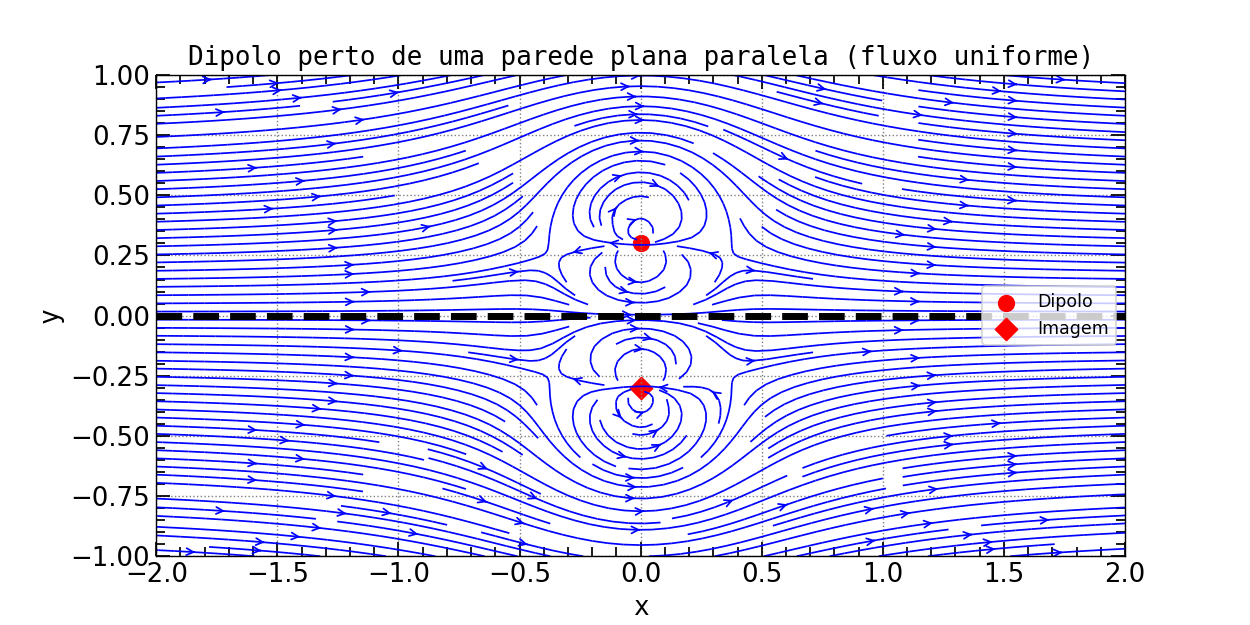

In [20]:
width = 10
height = (y_end - y_start) / (x_end - x_start) * width

plt.figure(figsize = (width, height))

plt.streamplot(X, Y, u, v, color = 'blue', density = 2, linewidth = 1, arrowsize = 1, arrowstyle = '->')
plt.scatter(doublet.x, doublet.y, color = 'red', s = 80, marker = 'o', label = r'Dipolo')
plt.scatter(doublet_image.x, doublet_image.y, color = 'red', s = 80, marker = 'D', label = r'Imagem')
plt.axhline(0.0, color = 'black', linestyle = '--', linewidth = 4)

plt.title('Dipolo perto de uma parede plana paralela (fluxo uniforme)', family = 'monospace', fontsize = 15)
plt.xlabel('x', family = 'monospace', fontsize = 15)
plt.ylabel('y', family = 'monospace', fontsize = 15)
plt.xlim(x_start, x_end)
plt.ylim(y_start, y_end)

plt.legend(loc = 'best')
opt_plot()

plt.savefig('Dipolo + parede plana + fluxo uniforme.png', dpi = 400)

---

## 2. Folha de fonte

Uma folha de fonte é uma linha infinita de origens ao longo de uma linha. No `Notebook` [Vórtices potenciais e sustentação aerodinâmica](https://github.com/GabrielWendell/PET.py/blob/main/Notebooks/Vórtices%20potenciais%20e%20sustentação%20aerodinâmica.ipynb) [1] foi ensinado a como criar uma folha de vórtice colocando uma linha de vórtices em uma linha, então você está pronto para isso.

Começamos importando nossas bibliotecas e criando a grade de pontos, como fizemos tantas vezes antes.

In [21]:
N = 100                               
x_start, x_end = -1.0, 1.0            
y_start, y_end = -1.5, 1.5            
x = np.linspace(x_start, x_end, N)    
y = np.linspace(y_start, y_end, N)    
X, Y = np.meshgrid(x, y)  

Incluiremos um escoamento uniforme de módulo $U_{\infty}=1$ paralelo ao eixo horizontal. Os arrays `u_freestream` e `v_freestream` contêm os componentes de velocidade do fluxo livre. Vamos preenchê-los:

In [22]:
u_inf = 1.0     

u_freestream = u_inf * np.ones((N, N), dtype = float)
v_freestream = np.zeros((N, N), dtype = float)

### 2.1 Número finito de fontes ao longo de uma linha

Consideramos primeiro um número finito de fontes dispostas ao longo de uma linha vertical, normal ao fluxo livre. As linhas de corrente sairão de cada fonte e serão desviadas pelas linhas de corrente provenientes do fluxo livre.

Do ponto de vista computacional, o número finito de fontes pode ser representado por um array 1D contendo objetos, cada um criado pela classe `Source`. Esta classe terá como atributos a força (`strength`) de uma fonte, força e sua localização em `(x, y)`. Seus métodos calcularão os componentes de velocidade e a função de fluxo em uma determinada malha de malha `(X, Y)` e, claro, seu *construtor*:

In [23]:
class Source:
    """
    Contém informações relacionadas a uma fonte/sumidouro.
    """
    def __init__(self, strength, x, y):
        """
        Define a localização e a força da singularidade.
        
        Parâmetros
        ----------
        strength: float
            Força da fonte/sumidouro.
        x: float
            Coordenada x da fonte/sumidouro.
        y: float
            Coordenada y da fonte/sumidouro.
        """
        self.strength = strength
        self.x, self.y = x, y

    def velocity(self, X, Y):
        """
        Calcula o campo de velocidade gerado pela fonte/sumidouro.
        
        Parâmetros
        ----------
        X: 2D Numpy array de floats
            Coordenada x dos pontos da malha.
        Y: 2D Numpy array de floats
            Coordenada y dos pontos da malha.
        
        Retorna
        -------
        u: 2D Numpy array of floats
            Componente x do campo de velocidade gerado pela fonte.
        v: 2D Numpy array of floats
            Componente y do campo de velocidade gerado pela fonte.
        """
        u = (self.strength / (2 * np.pi) *
             (X - self.x) / ((X - self.x)**2 + (Y - self.y)**2))
        v = (self.strength / (2 * np.pi) *
             (Y - self.y) / ((X - self.x)**2 + (Y - self.y)**2))
        return u, v

    def stream_function(self, X, Y):
        """
        Calcula a função de fluxo gerada pela fonte/sumidouro.
        
        Parâmetros
        ----------
        X: 2D Numpy array de floats
            Coordenada x dos pontos da malha.
        Y: 2D Numpy array de floats
            Coordenada y dos pontos da malha.
        
        Retorna
        -------
        psi: 2D Numpy array de floats
            Streamfunction gerado pela fonte.
        """
        psi = (self.strength / (2 * np.pi) *
               np.arctan2((Y - self.y), (X - self.x)))
        
        return psi

Agora você realmente verá como as classes são úteis! Usaremos nossa classe `Source` para criar quantas fontes quisermos colocar em uma planilha de fontes. Escolha um número, `N_sources`, e chame o construtor da classe muitas vezes, movendo-se ao longo do eixo $y$ para a localização das fontes. Em seguida, chame a função para calcular a velocidade de cada fonte.

In [24]:
N_sources = 11                               
strength = 5.0                                
strength_source = strength / N_sources        
x_source = np.zeros(N_sources, dtype = float)   
y_source = np.linspace(-1.0, 1.0, N_sources) 

sources = np.empty(N_sources, dtype = object)
for i in range(N_sources):
    sources[i] = Source(strength_source, x_source[i], y_source[i])

u = u_freestream.copy()
v = v_freestream.copy()
for source in sources:
    us, vs = source.velocity(X, Y)
    u += us
    v += vs

Observe que a variável sources é um array NumPy, ou seja, uma coleção de itens do mesmo tipo. Que tipo? Você provavelmente está acostumado com arrays de números, mas também podemos ter arrays de objetos de qualquer tipo criados por uma classe (neste caso, do tipo `Source`).

Estamos criando um array NumPy vazio chamado sources, e informando ao Python que seus itens serão algum objeto que não é um tipo de dado embutido, como `int` ou `float` para inteiros ou números reais de ponto flutuante. O número de itens contidos no array será `N_sources`.

No primeiro loop, preenchemos o array de fontes, chamando o *construtor* da classe `Source` para cada item. Também vamos em frente e calculamos a velocidade de cada fonte (usando o método `velocity()` de cada fonte). No segundo loop - depois de criar as matrizes de velocidade `u` e `v` copiando os componentes de velocidade de fluxo livre -, estamos aplicando o princípio da superposição calculando o campo de velocidade gerado por cada fonte e adicionando-o aos arrays de velocidade `u` e `v`.

O padrão de fluxo final corresponde à superposição de um fluxo uniforme e `N_sources` fontes idênticas de força `Strength_source` igualmente espaçadas ao longo de uma linha vertical normal ao fluxo uniforme. Em nosso gráfico, marcaremos a localização das fontes com pontos vermelhos e também definiremos um contorno preenchido de magnitude de velocidade para visualizar a localização do ponto de estagnação, definido por $u=0$ e $v=0$.

<IPython.core.display.Javascript object>


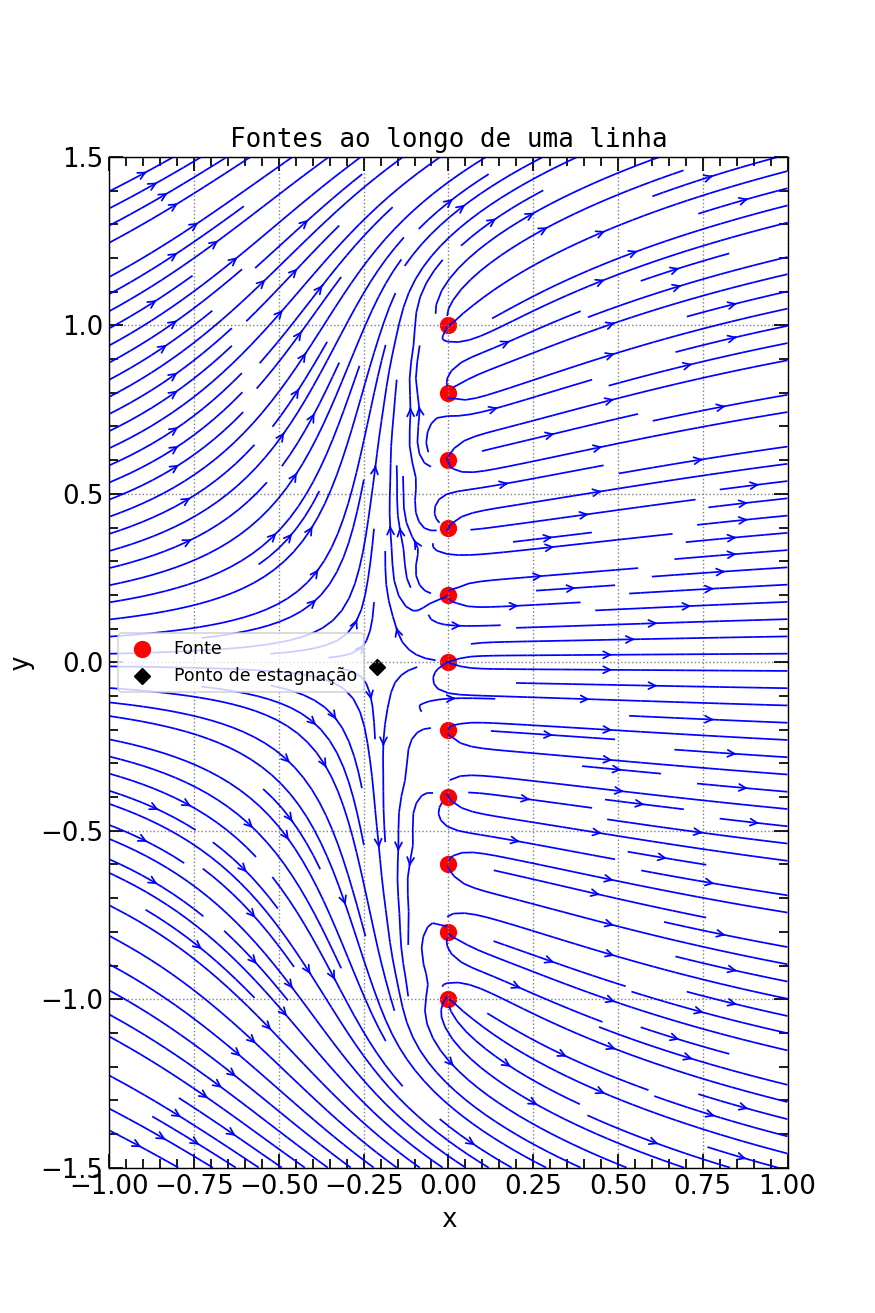

In [25]:
width = 7
height = (y_end - y_start) / (x_end - x_start) * width

plt.figure(figsize = (width, height))

plt.streamplot(X, Y, u, v, color = 'blue',
                  density = 2, linewidth = 1, arrowsize = 1, arrowstyle = '->')
# Plota as fontes
plt.scatter(x_source, y_source,
               color = 'red', s = 80, marker = 'o', label = 'Fonte')

# Calcula a magnitude da velocidade e os índices do ponto de estagnação
# Nota: o ponto de estagnação é aproximado como o ponto com a menor magnitude de velocidade
magnitude = np.sqrt(u**2 + v**2)
j_stagn, i_stagn = np.unravel_index(magnitude.argmin(), magnitude.shape)

# Plota o ponto de estagnação
plt.scatter(x[i_stagn], y[j_stagn],
               color = 'black', s = 40, marker = 'D', label = 'Ponto de estagnação')

plt.title('Fontes ao longo de uma linha', family = 'monospace', fontsize = 15)
plt.xlabel('x', family = 'monospace', fontsize = 15)
plt.ylabel('y', family = 'monospace', fontsize = 15)
plt.xlim(x_start, x_end)
plt.ylim(y_start, y_end)

opt_plot()
plt.legend(loc = 'best')

plt.savefig('Fontes ao longo de uma linha.png', dpi = 400)

Agora tente alterar a força total das fontes. Qual é a força mínima total da fonte para que a linha de corrente divisória ($\psi=0$) envolva todas as singularidades?

### 2.2 Linha infinita de fontes

Por definição, uma *folha de fonte* é uma coleção infinita de fontes lado a lado de força infinitesimal igual distribuída ao longo de um determinado caminho.

Considere $s$ a coordenada de deslocamento ao longo da folha: definimos $\sigma=\sigma(s)$ como a força por unidade de comprimento.

Lembre-se de que a força de uma única fonte representa a vazão volumétrica por unidade de profundidade (ou seja, por unidade de comprimento na direção $z$). Portanto, $\sigma$ representa a vazão volumétrica por unidade de profundidade e por unidade de comprimento (na direção s). Assim, $\sigma ds$ é a resistência de uma porção infinitesimal $ds$ da folha fonte. Esta porção infinitesimal é tão pequena que pode ser tratada como uma fonte distinta de força $\sigma ds$.

Em seguida, a função de fluxo no ponto $(r,\theta)$ desta porção infinitesimal será

$$d\psi\left(r,\theta\right) = \frac{\sigma ds}{2\pi} \theta$$

Integrando ao longo de $s$, encontramos a função de fluxo de toda a folha de fonte:

$$\psi(r,\theta)=\frac{\sigma}{2\pi}\int_{folha}\theta(s)ds$$

Na seção anterior, consideramos uma distribuição vertical finita de fontes. Da mesma forma, a função de fluxo de uma folha de fonte vertical em $x=0$ entre $y_{min.}$ e $y_{max.}$ em coordenadas cartesianas será

$$\psi\left(x,y\right) = \frac{\sigma}{2\pi}\int_{y_{\text{min}}}^{y_{\text{max}}} \tan^{-1}\left(\frac{y-\xi}{x}\right)d\xi$$

E as componentes da velocidade serão

$$u\left(x,y\right) = \frac{\sigma}{2\pi} \int_{y_{\text{min}}}^{y_{\text{max}}} \frac{x}{x^2+\left(y-\xi\right)^2}d\xi$$

$$v\left(x,y\right) = \frac{\sigma}{2\pi} \int_{y_{\text{min}}}^{y_{\text{max}}} \frac{y-\xi}{x^2+\left(y-\xi\right)^2}d\xi$$

### 2.3 Usando o `SciPy`

Precisamos calcular as duas integrais acima para obter as velocidades. *Caramba!*, você diz. Calcular integrais é tão ultrapassado. Não se preocupe! Temos SciPy: uma poderosa coleção de algoritmos e funções matemáticas. Inclui o módulo [`integrate`](https://docs.scipy.org/doc/scipy/tutorial/integrate.html), um conjunto fundamental de funções para computação científica, incluindo integração básica, regras de quadratura e integradores numéricos para equações diferenciais ordinárias. Quão útil é isso?

Vamos importar o módulo que precisamos do SciPy:

Vamos usar a função [`quad(func,a,b)`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html#scipy.integrate.quad) do módulo `integrate` para calcular a integral definida de uma função de uma variável entre dois limites:

$$I=\int_{a}^{b}f(x)dx$$

O primeiro argumento para a função quad precisa ser uma função Python... você já sabe como criar uma função Python usando uma instrução `def`, mas aprenderá uma nova maneira de criar funções Python: a instrução `lambda`. Por que preciso de duas maneiras de definir funções, você pode perguntar? A resposta é bastante sutil.

Resumindo, uma função criada com uma instrução `lambda` é uma única expressão que retorna um valor (mas sem uma instrução do tipo `return`). Geralmente é chamada de *função anônima*, porque não precisamos dar um nome a ela.

Vamos ver como usamos uma instrução lambda para integrar uma função matemática. Suponha que queremos integrar a função $f:x\rightarrow x^{2}$ de $0$ a $1$. Você pode fazer isso manualmente, certo? Dá o valor $\frac{1}{3}$.

Para usar a função `quad()`, damos como primeiro parâmetro a expressão `lambda x : x**2`:

In [26]:
print(integrate.quad(lambda x: x**2, 0.0, 1.0))

(0.33333333333333337, 3.700743415417189e-15)


Veja bem, aqui usamos a instrução `lambda` para passar um argumento de função para `quad()`, sem passar por uma definição de função (neste sentido, falamos de funções anônimas do Python).

Observe que a função `quad()` retorna uma lista: o primeiro elemento é o resultado da integral e o segundo elemento é uma estimativa do erro. Se você quer apenas o valor da integral definida, você precisa especificar o índice `[0]`, para o primeiro elemento da lista!

Observe que a função `lambda` pode aceitar vários argumentos:

In [27]:
a = 3.0
print(integrate.quad(lambda x, a: a * x**2, 0.0, 1.0, args = a))

b = 2.0
print(integrate.quad(lambda x, a, b: a * b * x**2, 0.0, 1.0, args = (a, b)))

(1.0, 1.1102230246251565e-14)
(2.0, 2.220446049250313e-14)


Estamos prontos para usar isso para nossos cálculos de velocidade da folha de fonte.

Uma última coisa! O resultado da integral, obtido com a função `quad()` é um float, então teríamos que fazer um loop sobre nosso domínio para calcular a integral em cada ponto discreto; isso pode se tornar caro à medida que refinamos nosso domínio... A menos que usemos [`numpy.vectorize()`](https://numpy.org/doc/stable/reference/generated/numpy.vectorize.html) que nos permitirá criar uma função vetorizada que recebe arrays Numpy como entradas e retorna um array Numpy!

In [28]:
sigma = 2.5    

# Limites da folha de fonte
y_min, y_max = -1.0, 1.0

# Criamos as funções anônimas
integrand_u = lambda s, x, y: x / (x**2 + (y - s)**2)
integrand_v = lambda s, x, y: (y - s) / (x**2 + (y - s)**2)

# Cria uma função fictícia para vetorizar
def integration(x, y, integrand):
    return integrate.quad(integrand, y_min, y_max, args = (x, y))[0]

vec_integration = np.vectorize(integration)

# Calcula o campo de velocidade gerado pela folha-fonte
u_sheet = sigma / (2.0 * np.pi) * vec_integration(X, Y, integrand_u)
v_sheet = sigma / (2.0 * np.pi) * vec_integration(X, Y, integrand_v)

# Superposição da folha-fonte ao fluxo uniforme
u = u_freestream + u_sheet
v = v_freestream + v_sheet

Vamos agora visualizar as linhas de corrente (azul) na grade de malha. Desenhamos uma linha vermelha para mostrar a folha de fonte e um contorno preenchido para visualizar a localização do ponto de estagnação.

<IPython.core.display.Javascript object>


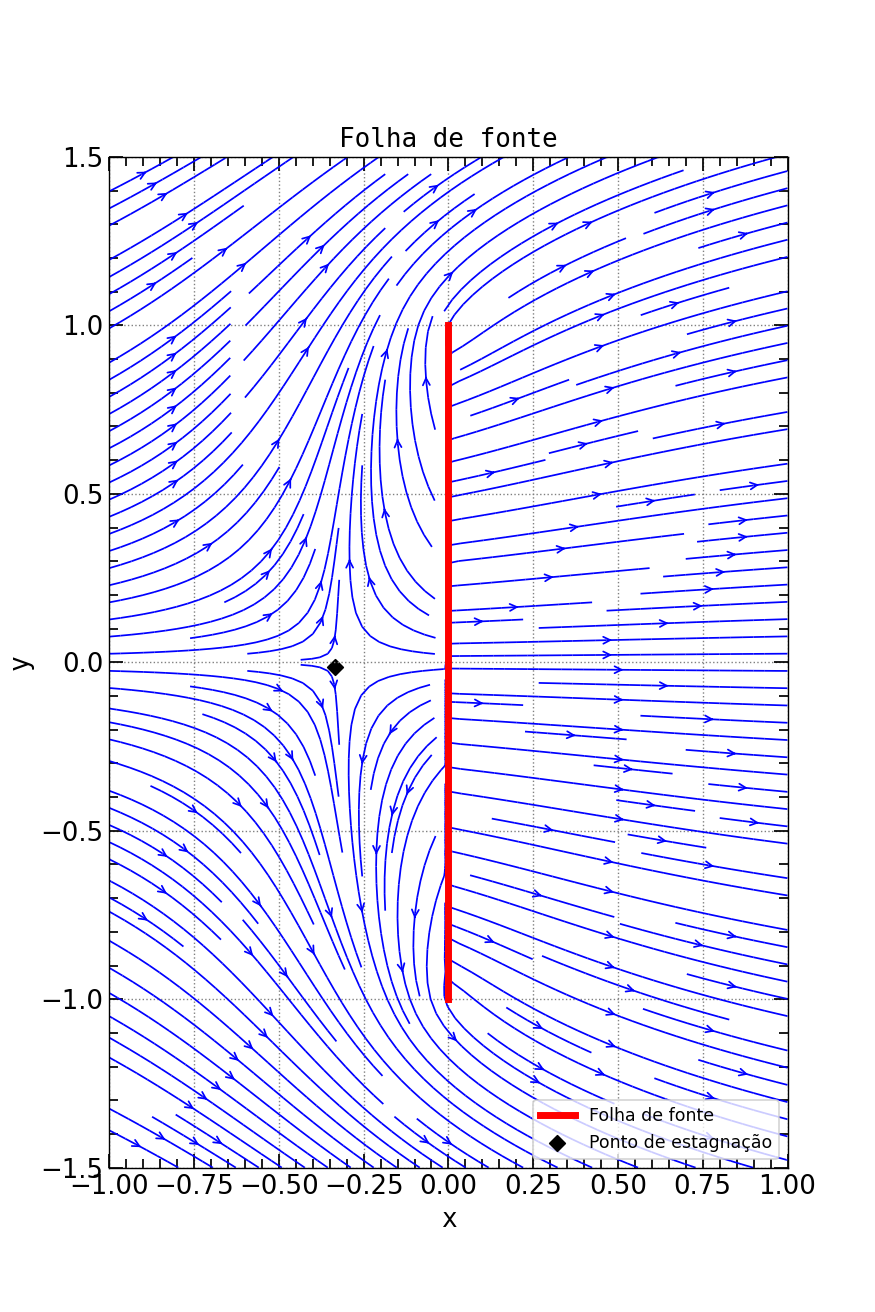

In [29]:
width = 7
height = (y_end - y_start) / (x_end - x_start) * width

plt.figure(figsize = (width, height))

plt.streamplot(X, Y, u, v, color = 'blue',
                  density = 2, linewidth = 1, arrowsize = 1, arrowstyle = '->')
# Plota a folha de fonte
plt.axvline(0.0,
               (y_min - y_start) / (y_end - y_start),
               (y_max - y_start) / (y_end - y_start),
               color = 'red', linewidth = 4, label = 'Folha de fonte')

# Calcula a magnitude da velocidade e os índices do ponto de estagnação
# Nota: o ponto de estagnação é aproximado como o ponto com a menor magnitude de velocidade
magnitude = np.sqrt(u**2 + v**2)
j_stagn, i_stagn = np.unravel_index(magnitude.argmin(), magnitude.shape)

# Plota o ponto de estagnação
plt.scatter(x[i_stagn], y[j_stagn],
               color = 'black', s = 40, marker = 'D', label = 'Ponto de estagnação')

plt.title('Folha de fonte', family = 'monospace', fontsize = 15)
plt.xlabel('x', family = 'monospace', fontsize = 15)
plt.ylabel('y', family = 'monospace', fontsize = 15)
plt.xlim(x_start, x_end)
plt.ylim(y_start, y_end)

opt_plot()
plt.legend(loc = 'best')

plt.savefig('Folha de fonte.png', dpi = 400)

Dissemos que a força $\sigma$ representa uma vazão volumétrica que emana da folha fonte. Se você jogar com este parâmetro, verá que o ponto de estagnação se aproxima cada vez mais da folha de origem com força decrescente.

Se quisermos usar várias folhas de fonte para representar as linhas de corrente em torno de uma determinada forma de corpo, precisamos tornar cada folha de origem parte da linha de corrente divisória. A questão será *qual é a força da fonte para que isso aconteça?*

A vazão volumétrica no lado esquerdo da folha é $\frac{\sigma}{2}$, fluindo na direção oposta da velocidade da corrente livre $U_{\infty}$. Portanto, a condição de contorno de tangência de fluxo requerida é $\frac{\sigma}{2}=U_{\infty}$.

Agora volte para o código acima e substitua o `sigma` pelo valor correto. *Onde está o ponto de estagnação? Onde está a linha divisória?*

### 2.4 Sobre as funções `lambda`

A instrução `lambda` pode ser especialmente confusa quando você está começando com o Python. Aqui estão alguns lugares para se aprofundar:

- um post de blog interessante que trata das sutilezas das funções `lambda`: [Yet Another Lambda Tutorial](https://pythonconquerstheuniverse.wordpress.com/2011/08/29/lambda_tutorial/) [3] no blog *Python Conquers the Universe* (29 de agosto de 2011)

- o capítulo sobre ["Anonymous functions: lambda"](https://www.inkling.com/read/learning-python-mark-lutz-4th/chapter-19/anonymous-functions-lambda) [4] do livro *Learning Python* de Mark Lutz.

---

## 3. Fluxo sobre um cilindro com painéis de fonte

Nos `Notebooks` anteriores, usamos singularidades de fluxo potencial de força definida para representar a forma de geometrias simples, como uma oval de Rankine ou um cilindro circular, imerso em um fluxo livre. Tivemos muita sorte que, ao sobrepor algumas soluções fundamentais de fluxo potencial, o padrão de linha de fluxo resultante tinha uma linha de fluxo divisória fechada que poderíamos interpretar como um corpo sólido.

Mas e se quisermos representar as linhas de corrente em torno de uma geometria arbitrária? Você seria capaz de definir a combinação de soluções fundamentais para obter o resultado esperado? *Como você pode fazer aquilo?* Tentativa e erro? Seria preciso muita sorte e muito trabalho para obter a geometria que queremos.

Nesta seção, o objetivo é calcular a distribuição de força da fonte que pode produzir fluxo potencial em torno de uma determinada geometria: um cilindro circular. Sabemos que podemos obter o escoamento em torno de um cilindro sobrepondo um dublê em um fluxo livre, mas aqui queremos desenvolver uma abordagem mais geral que posteriormente pode ser estendida a *diferentes* formas.

O método que usaremos consiste em representar a geometria do corpo por uma série de segmentos lineares curtos, chamados painéis, que correspondem a folhas de fonte como abordada na seção anterior.

O que estamos buscando é um método que comece com uma geometria de corpo definida e, em seguida, trabalhe a força das fontes necessárias em cada painel que representa essa geometria para obter uma linha de fluxo divisória bem no limite do corpo. Teremos que *resolver* as forças da fonte especificando que o corpo seja uma linha de corrente, ou seja, a velocidade seja tangente a ela.

Vamos adicionar um fluxo horizontal uniforme de magnitude `u_inf`, então vamos torná-lo igual a 1:

In [30]:
u_inf = 1.0

### 3.1 Definição da geometria

A geometria considerada aqui será um cilindro circular de raio unitário. Podemos definir essa geometria muito facilmente por um conjunto de pontos que circundam a faixa angular entre $0$ e $2\pi$.

Definimos o cilindro de raio unitário centrado em $(0, 0)$:

In [31]:
R = 1.0
x_center, y_center = 0.0, 0.0
theta = np.linspace(0.0, 2 * np.pi, 100)
x_cylinder, y_cylinder = (x_center + R * np.cos(theta),
                          y_center + R * np.sin(theta))

Agora vamos plotar o cilindro:

<IPython.core.display.Javascript object>


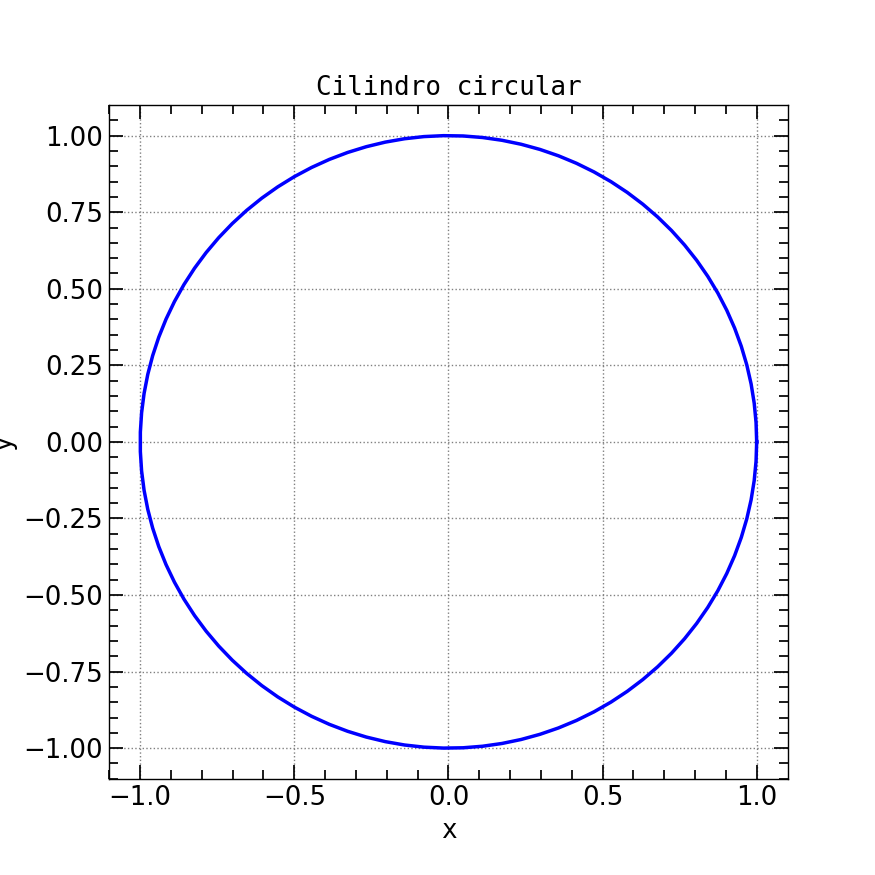

In [32]:
size = 7
plt.figure(figsize = (size, size))

plt.plot(x_cylinder, y_cylinder, color = 'blue', linestyle = '-', linewidth = 2)

plt.title('Cilindro circular', family = 'monospace', fontsize = 15)
plt.xlabel('x', family = 'monospace', fontsize = 15)
plt.ylabel('y', family = 'monospace', fontsize = 15)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

opt_plot()

plt.savefig('Cilindro circular.png', dpi = 400)

### 3.2 Discretização em painéis

Um painel, que representa uma folha de origem, é definido por seus dois pontos finais `(xa, ya)` e `(xb, yb)` e sua força sigma. Também precisaremos de seu ponto central `(xc, yc)` e seu comprimento para cálculos adicionais. A orientação do painel é definida pelo ângulo entre o eixo $x$ e sua normal no sentido anti-horário.

Que informações precisamos computar em cada painel? Antes de tudo, precisaremos da força da folha de origem que levará às linhas de corrente corretas. Além disso, também queremos a velocidade tangencial (a velocidade normal no corpo é zero para um fluxo invíscido) e o coeficiente de pressão.

Nesta seção, você realmente apreciará ter aprendido sobre as seções anteriores. Isso tornará o código muito mais fácil de gerenciar. Criamos uma classe chamada `Panel` contendo todos os dados de geometria relacionados a um painel. Com um ponto inicial e um ponto final, a classe calcula internamente o ponto central, o comprimento e o vetor normal. Também inicializa para zero a força da fonte, a velocidade tangencial e o coeficiente de pressão. (Estes serão atualizados posteriormente.)

In [33]:
class Panel:
    """
    Contém informações relacionadas a um painel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Inicializa o painel.
        
        Define os pontos finais e calcula o centro, comprimento e ângulo 
        (com o eixo x) do painel.
         
        Inicializa a força da folha de origem, a velocidade tangencial, 
        e o coeficiente de pressão para zero.
        
        Parâmetros
        ----------
        xa: float
            Coordenada x do primeiro ponto final.
        ya: float
            Coordenada y do primeiro ponto final.
        xb: float
            Coordenada x do segundo ponto final.
        yb: float
            Coordenada y do segundo ponto final.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2 
        self.length = np.sqrt((xb - xa)**2 + (yb - ya)**2)  
        
        # Orientação do painel (ângulo entre o eixo x e o normal do painel)
        if xb - xa <= 0.:
            self.beta = np.arccos((yb - ya) / self.length)
        elif xb - xa > 0.:
            self.beta = np.pi + np.arccos(-(yb - ya) / self.length)
        
        self.sigma = 0.0  
        self.vt = 0.0  
        self.cp = 0.0  

Para armazenar toda a discretização, criamos um array NumPy de tamanho `N_panels` onde cada item do array é um objeto do tipo `Panel`.

In [34]:
N_panels = 10  

x_ends = R * np.cos(np.linspace(0.0, 2 * np.pi, N_panels + 1))
y_ends = R * np.sin(np.linspace(0.0, 2 * np.pi, N_panels + 1))

panels = np.empty(N_panels, dtype = object)
for i in range(N_panels):
    panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i + 1], y_ends[i + 1])

Agora vamos ao plot:

<IPython.core.display.Javascript object>


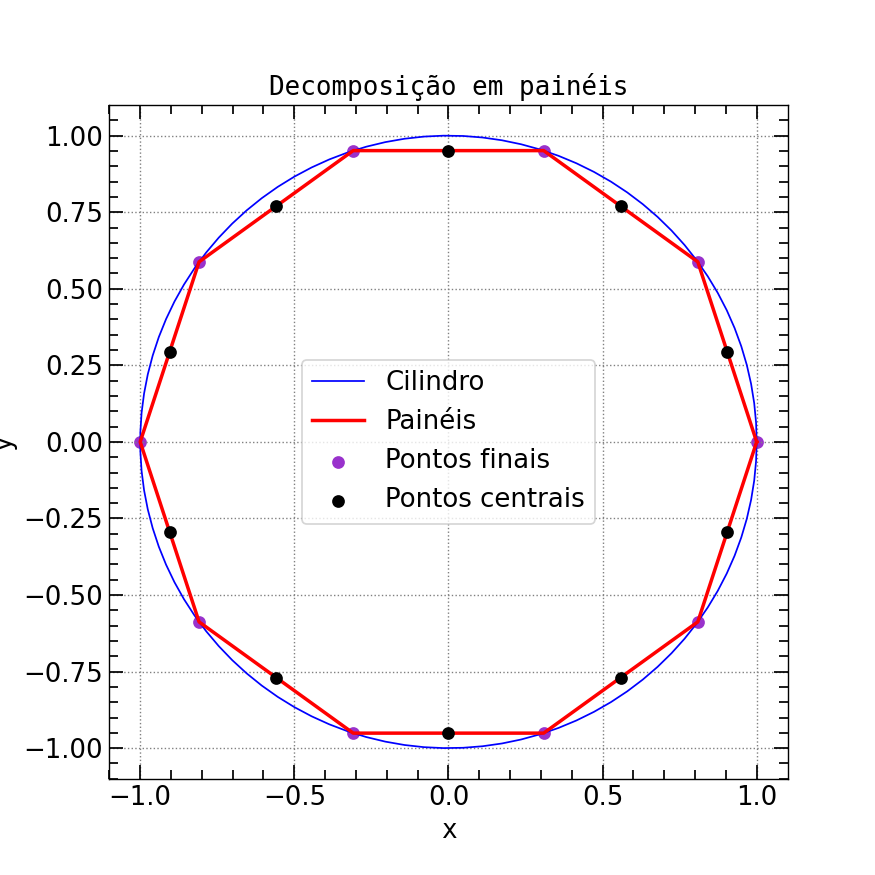

In [35]:
size = 7
plt.figure(figsize = (size, size))

plt.plot(x_cylinder, y_cylinder,
            label = 'Cilindro',
            color = 'blue', linestyle = '-', linewidth = 1)
plt.plot(x_ends, y_ends,
            label = 'Painéis',
            color = 'red', linestyle = '-', linewidth = 2)

plt.scatter([p.xa for p in panels], [p.ya for p in panels],
               label = 'Pontos finais',
               color = 'darkorchid', s = 40)
plt.scatter([p.xc for p in panels], [p.yc for p in panels],
               label = 'Pontos centrais',
               color = 'black', s = 40, zorder = 3)

plt.title('Decomposição em painéis', family = 'monospace', fontsize = 15)
plt.xlabel('x', family = 'monospace', fontsize = 15)
plt.ylabel('y', family = 'monospace', fontsize = 15)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

plt.legend(loc='best', prop = {'size':15})
opt_plot()

plt.savefig('Decomposição em painéis.png', dpi = 400)

### 3.3 Condição de contorno de fluxo-tangência

No `Notebook` [fontes, sumidouros e dipolos](https://github.com/GabrielWendell/PET.py/blob/main/Notebooks/Fontes%2C%20Sumidouros%20e%20Dipolos.ipynb) [2], você calculou o potencial de velocidade de uma única fonte como parte do **Para refletir...**. Decorreu simplesmente da integração da velocidade radial, $u_{r}=\frac{\sigma}{2\pi r}$, que é dada por

$$\phi=\frac{\sigma}{2\pi}\ln{r}$$

(A integração também fornece uma função de $\theta$ que é vista como constante porque $u_{\theta}=0$; tomamos essa constante como zero.)

Usaremos o potencial de velocidade nesta etapa do `Notebook` para expressar facilmente que a velocidade é tangente ao painel, ou seja, que $u_{n}=0$ com:

$$u_n(x,y)=\frac{\partial \phi}{\partial n}(x,y)$$

em um determinado ponto do painel. Escolhemos o ponto para impor essa condição de velocidade-tangência como o centro do painel (e o chamamos de *ponto de controle*).

O potencial de velocidade em coordenadas cartesianas de uma folha fonte em um painel é dada por

$$\phi\left(x,y\right) = \frac{\sigma}{2\pi} \int_\text{painel} \ln \sqrt{ \left[x-x(s)\right]^2 + \left[y-y(s)\right]^2 } {\rm d}s$$

onde $s$ é a coordenada de corrida ao longo do painel e $(x(s),y(s))$ são as coordenadas cartesianas de $s$.

A superposição do potencial de cada painel dá o potencial total em qualquer ponto $(x,y)$, então fazemos uma soma de todas as contribuições do painel da seguinte forma (movendo o expoente $\frac{1}{2}$ no termo logarítmico como um fator fora da integral):

$$\phi\left(x,y\right) = \sum_{j=1}^{N_p} \frac{\sigma_j}{4\pi} \int \ln \left\{ \left[x-x_j(s_j)\right]^2 + \left[y-y_j(s_j)\right]^2 \right\} {\rm d}s_j$$

Ao finalmente sobrepor a corrente livre, o escoamento em torno de um cilindro circular imerso será representado pelo seguinte potencial de velocidade:

$$\phi\left(x,y\right) = U_\infty x + \sum_{j=1}^{N_p} \frac{\sigma_j}{4\pi} \int \ln \left\{ \left[x-x_j(s_j)\right]^2 + \left[y-y_j(s_j)\right]^2 \right\} {\rm d}s_j$$

A imposição da condição de fluxo-tangência em cada ponto de controle aproximadamente faz com que a geometria do corpo corresponda a uma linha de corrente divisória (e a aproximação melhora se representarmos o corpo com mais e mais painéis). Então, para cada painel $i$, fazemos $u_{n}=0$ em $(x_{c_{i}},y_{c_{i}})$:

$$u_{n_i} = \frac{\partial}{\partial n_i}\left\lbrace \phi\left(x_{c_i},y_{c_i}\right) \right\rbrace = 0$$

o que por sua vez resulta em

$$0 = U_\infty \cos\beta_i + \sum_{j=1}^{N_p} \frac{\sigma_j}{2\pi} \int \frac{\left[x_{c_i}-x_j(s_j)\right] \frac{\partial x_{c_i}}{\partial n_i} + \left[y_{c_i}-y_j(s_j)\right] \frac{\partial y_{c_i}}{\partial n_i}} {\left[x_{c_i}-x_j(s)\right]^2 + \left[y_{c_i}-y_j(s)\right]^2} {\rm d}s_j$$

onde $\beta_{i}$ é o ângulo que a normal do painel faz com o eixo $x$, então

$$\frac{\partial x_{c_i}}{\partial n_i} = \cos\beta_i \quad \text{e}\quad\frac{\partial y_{c_i}}{\partial n_i} = \sin\beta_i$$

além disso, temos que

$$x_j(s_j) = x_{a_j} -  \sin\left(\beta_j\right) s_j$$

$$y_j(s_j) = y_{a_j} + \cos\left(\beta_j\right) s_j$$

Mas ainda há um problema a ser tratado quando $i=j$. Da seção anterior, vimos que a resistência da folha de fonte deve ser um valor específico para que as linhas de corrente não penetrem no painel. Isso nos ajuda a determinar que a contribuição do $i$-ésimo painel para si mesmo é $\frac{\sigma_{i}}{2}$.

Finalmente, a condição de contorno no ponto central do $i$-ésimo painel fornece

$$0 = U_\infty \cos\beta_i + \frac{\sigma_i}{2} + \sum_{j=1,j\neq i}^{N_p} \frac{\sigma_j}{2\pi} \int \frac{\left[x_{c_i}-x_j(s_j)\right] \cos\beta_i + \left[y_{c_i}-y_j(s_j)\right] \sin\beta_i} {\left[x_{c_i}-x_j(s)\right]^2 + \left[y_{c_i}-y_j(s)\right]^2} {\rm d}s_j$$

Da equação acima, entendemos que teremos que calcular integrais usando a função SciPy `integrate.quad()`. Definimos uma função `integral_normal()` que fará o trabalho.

In [36]:
def integral_normal(p_i, p_j):
    """
    Avalia a contribuição de um painel no centro de outro, 
    na direção normal.
    
    Parâmetros
    ----------
    p_i: Painel object
        Painel no qual a contribuição é calculada.
    p_j: Painel object
        Painel a partir do qual a contribuição é calculada.
    
    Retorna
    -------
    Integral sobre o painel no ponto central do outro.
    """
    def integrand(s):
        return (((p_i.xc - (p_j.xa - np.sin(p_j.beta) * s)) * np.cos(p_i.beta) +
                 (p_i.yc - (p_j.ya + np.cos(p_j.beta) * s)) * np.sin(p_i.beta)) /
                ((p_i.xc - (p_j.xa - np.sin(p_j.beta) * s))**2 +
                 (p_i.yc - (p_j.ya + np.cos(p_j.beta) * s))**2))
    
    return integrate.quad(integrand, 0.0, p_j.length)[0]

### 3.4 Resolvendo o sistema de equações

Acabamos de desenvolver uma equação para impor uma condição de fluxo-tangência no $i$-ésimo painel. Existem `N_panels` painéis $i$ e `N_panels` com intensidades desconhecidas $\sigma_{i}$. Portanto, o problema representa resolver um sistema linear de equações da forma

$$[A][\sigma] = [b]$$

onde

$$A_{ij} = \begin{cases}
\begin{matrix}
\frac{1}{2} & \mbox{, se } i=j \cr
\frac{1}{2\pi} \int \frac{\left[x_{c_i}-x_j(s_j)\right] \cos{\beta_i} + \left[y_{c_i}-y_j(s_j)\right] \sin\beta_i} {\left[x_{c_i}-x_j(s)\right]^2 + \left[y_{c_i}-y_j(s)\right]^2} ds_j & \mbox{, se } i\neq j
\end{matrix}
\end{cases}$$

além disso

$$b_i = - U_\infty \cos\beta_i$$

para $1\geq i$, $j\geq N_{p}$. Vamos preencher uma matriz $A$ e um vetor do lado direito $b$ com os valores necessários:

In [37]:
# Calcula a matriz de influência da fonte
A = np.empty((N_panels, N_panels), dtype = float)
np.fill_diagonal(A, 0.5)

for i, p_i in enumerate(panels):
    for j, p_j in enumerate(panels):
        if i != j:
            A[i, j] = 0.5 / np.pi * integral_normal(p_i, p_j)

# Calcula o RHS do sistema linear
b = - u_inf * np.cos([p.beta for p in panels])

Hey! Acabamos de usar uma nova função interna do Python: [`enumerate()`](https://docs.python.org/2/library/functions.html#enumerate). Ele nos permite ter acesso a cada painel de elemento nos painéis do array mantendo uma contagem `i` (que começa em `0`) para localizar o elemento de `A` ser preenchido.

Agora, podemos resolver facilmente o sistema linear de equações usando a função [`linalg.solve()`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html) do NumPy e atribuir a cada painel de origem sua força apropriada:

In [38]:
# Resolve o sistema linear
sigma = np.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.sigma = sigma[i]

### 3.5 Coeficiente de pressão na superfície

Neste ponto, temos a distribuição de força da fonte necessária para calcular as linhas de corrente em torno de nossa geometria. Uma medida muito útil dos resultados é o coeficiente de pressão ao longo da superfície da geometria.

Da equação de Bernoulli, o coeficiente de pressão no $i$-ésimo painel é

$$C_{p_i} = 1-\left(\frac{u_{t_i}}{U_\infty}\right)^2$$

onde $u_{t_{i}}$ é a componente tangencial da velocidade no ponto central do $i$-ésimo painel,

$$u_{t_i} = \frac{\partial}{\partial t_i}\left\lbrace \phi\left(x_{c_i},y_{c_i}\right) \right\rbrace$$

que podemos obter como:

$$\boxed{u_{t_i} = -U_\infty \sin\beta_i + \sum_{j=1}^{N_p} \frac{\sigma_j}{2\pi} \int \frac{\left[x_{c_i}-x_j(s_j)\right] \frac{\partial x_{c_i}}{\partial t_i} + \left[y_{c_i}-y_j(s_j)\right] \frac{\partial y_{c_i}}{\partial t_i}} {\left[x_{c_i}-x_j(s)\right]^2 + \left[y_{c_i}-y_j(s)\right]^2} {\rm d}s_j}$$

onde temos que 

$$\frac{\partial x_{c_i}}{\partial t_i} = -\sin\beta_i \quad\text{e} \quad \frac{\partial y_{c_i}}{\partial t_i} = \cos\beta_i$$

Observe que a contribuição para a velocidade tangencial em um painel de fonte de seu próprio potencial de velocidade é zero, o que faz sentido porque as linhas de corrente *saem* de uma fonte.

Definimos uma função `integral_tangential()` que calculará as integrais acima usando a função SciPy `integrate.quad()` mais uma vez:

In [39]:
def integral_tangential(p_i, p_j):
    """
    Avalia a contribuição de um painel no centro de outro, 
    na direção tangencial.
    
    Parâmetro
    ----------
    p_i: Painel object
        Painel no qual a contribuição é calculada.
    p_j: Painel object
        Painel a partir do qual a contribuição é calculada.
    
    Retorna
    -------
    Integral sobre o painel no ponto central do outro.
    """
    def integrand(s):
        return ((-(p_i.xc - (p_j.xa - np.sin(p_j.beta) * s)) * np.sin(p_i.beta) +
                 (p_i.yc - (p_j.ya + np.cos(p_j.beta) * s)) * np.cos(p_i.beta)) /
                ((p_i.xc - (p_j.xa - np.sin(p_j.beta) * s))**2 +
                 (p_i.yc - (p_j.ya + np.cos(p_j.beta) * s))**2))
    
    return integrate.quad(integrand, 0.0, p_j.length)[0]

Analogamente a como fizemos anteriormente:

In [40]:
# Calcula a matriz do sistema linear
A = np.empty((N_panels, N_panels), dtype = float)
np.fill_diagonal(A, 0.0)

for i, p_i in enumerate(panels):
    for j, p_j in enumerate(panels):
        if i != j:
            A[i, j] = 0.5 / np.pi * integral_tangential(p_i, p_j)

# Calcula o RHS do sistema linear
b = - u_inf * np.sin([panel.beta for panel in panels])

# Calcula a velocidade tangencial em cada ponto central do painel
vt = np.dot(A, sigma) + b

for i, panel in enumerate(panels):
    panel.vt = vt[i]

Uma vez calculada a velocidade tangencial em cada painel, podemos calcular o coeficiente de pressão.

In [41]:
for panel in panels:
    panel.cp = 1.0 - (panel.vt / u_inf)**2

Tudo bem! É hora de traçar o coeficiente de pressão de superfície.

Pouco antes disso, devemos lembrar que no `Notebook` [fontes, sumidouros e dipolos](https://github.com/GabrielWendell/PET.py/blob/main/Notebooks/Fontes%2C%20Sumidouros%20e%20Dipolos.ipynb) [2], descobrimos que o coeficiente de pressão exato na superfície de um cilindro era dado por

$$\boxed{Cp = 1 - 4\sin^2 \theta\iff Cp = 1 - 4\left(\frac{y}{R}\right)^2}$$

Podemos usar isso para comparar com os resultados obtidos com nosso código do painel-fonte.

<IPython.core.display.Javascript object>


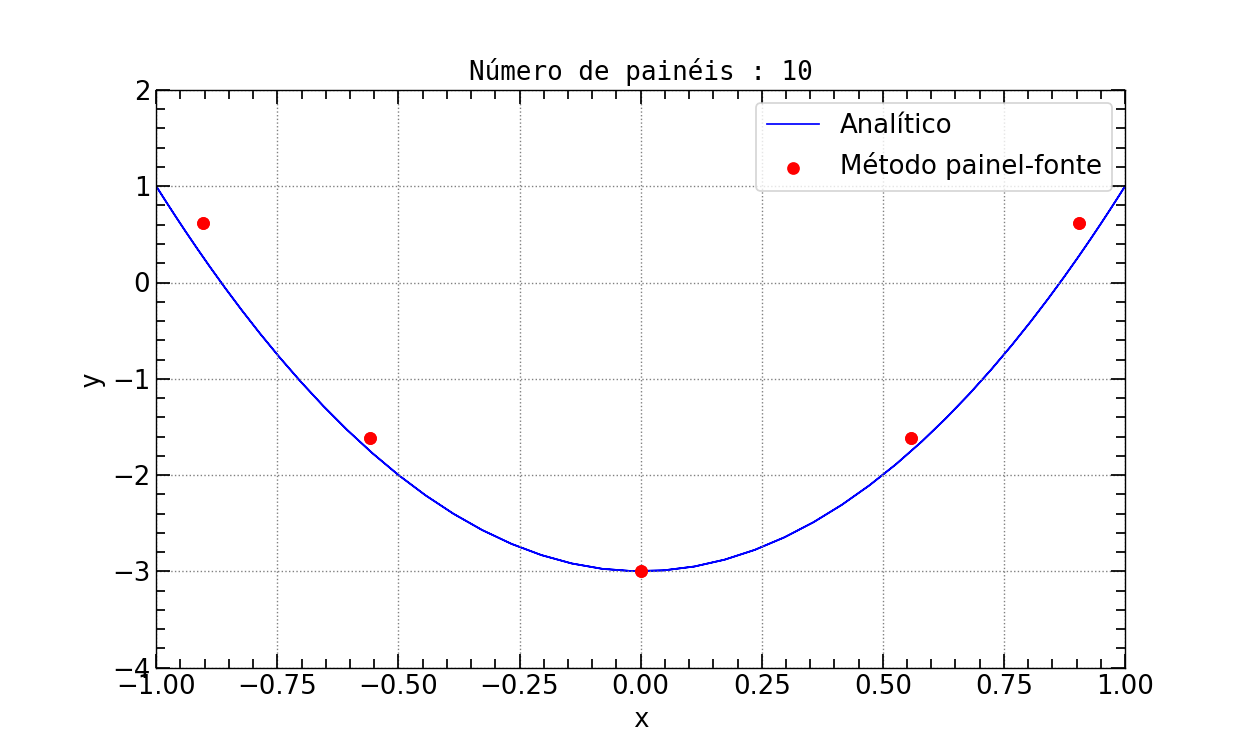

In [42]:
# Calcula o coeficiente analítico de pressão superficial
cp_analytical = 1.0 - 4 * (y_cylinder / R)**2

# Plotamos o coeficiente de pressão de superfície
plt.figure(figsize = (10, 6))

plt.plot(x_cylinder, cp_analytical,
            label = 'Analítico',
            color = 'blue', linestyle = '-', linewidth = 1, zorder = 1)
plt.scatter([p.xc for p in panels], [p.cp for p in panels],
               label = 'Método painel-fonte',
               color = 'red', s = 40, zorder = 2)

plt.title('Número de painéis : %d' % N_panels, family = 'monospace', fontsize = 15)
plt.xlabel('x', family = 'monospace', fontsize = 15)
plt.ylabel('y', family = 'monospace', fontsize = 15)
plt.xlim(-1.0, 1.0)
plt.ylim(-4.0, 2.0)

plt.legend(loc = 'best', prop = {'size':15})
opt_plot()

plt.savefig('Método do painel-fonte.png', dpi = 400)

### 3.6 Desafio

Agora que calculamos o coeficiente de pressão na superfície do cilindro, será interessante visualizar como são as linhas de corrente.

Para isso, usamos a função `streamplot()` do Matplotlib, exigindo as componentes cartesianas de velocidade `(u,v)` em uma malha de grade `(X,Y)`. Portanto, o primeiro passo é derivar as equações para os componentes da velocidade.

O potencial no ponto $(x,y)$ das folhas de fonte $N_{p}$ em um fluxo horizontal uniforme $U_{\infty}$ é

$$\boxed{\phi\left(x,y\right) = U_\infty x + \sum_{j=1}^{N_p} \frac{\sigma_j}{4\pi} \int \ln \left\{ \left[x-x_j(s_j)\right]^2 + \left[y-y_j(s_j)\right]^2 \right\} {\rm d}s_j}$$

E o campo de velocidade no ponto $(x,y)$ é

$$u\left(x,y\right) = \frac{\partial}{\partial x}\left\lbrace \phi\left(x,y\right) \right\rbrace$$

$$v\left(x,y\right) = \frac{\partial}{\partial y}\left\lbrace \phi\left(x,y\right) \right\rbrace$$

Sua tarefa será:

- derivar os componentes da velocidade cartesiana;
- criar uma grade de malha;
- calcular o campo de velocidade na grade de malha;
- plotar os resultados;
- altere o número de painéis para melhorar a visualização.

---

## 4. Método do painel de origem

No `Notebook` [fontes, sumidouros e dipolos](https://github.com/GabrielWendell/PET.py/blob/main/Notebooks/Fontes%2C%20Sumidouros%20e%20Dipolos.ipynb) [2] foram introduzidas as soluções fundamentais de fluxo potencial e rapidamente aprendemos que, usando nossos poderes de superposição, poderíamos obter alguns resultados úteis em aerodinâmica.

A superposição de um dipolo e um fluxo livre deu o fluxo em torno de um cilindro circular, e aprendemos sobre o *paradoxo de D'Alembert*: o resultado do arrasto zero para o fluxo potencial em torno de um cilindro. Adicionando um **vórtice** no centro do cilindro, aprendemos sobre sustentação e o *teorema de Kutta-Joukowski* afirmando que a sustentação é proporcional à circulação: $L=\rho U\Gamma$. Um resultado mais importante!

Adicionar soluções fundamentais de fluxo potencial e ver o que obtemos ao interpretar uma linha de corrente divisória como um corpo sólido é frequentemente chamado de *método indireto*. Este método remonta a Rankine em 1871. Mas sua aplicabilidade é limitada porque não podemos estipular uma geometria e encontrar o fluxo associado a ela.

Na seção anterior, aprendemos que é possível estipular primeiro a geometria e, em seguida, resolver as forças da fonte em um painel de discretização do corpo que torna o escoamento tangente ao limite. Isso é chamado de *método direto* e decolou na década de 1960 com o trabalho de Hess e Smith na *Douglas Aircraft Company*.

Um conjunto de painéis (segmentos de linha em 2D) pode representar a superfície de qualquer corpo sólido imerso em um fluxo potencial fazendo as forças da folha fonte de modo que a velocidade normal em cada painel seja igual a zero. Essa é uma ideia muito poderosa! Mas você deve perceber que todas as forças do painel estão acopladas umas às outras, e é por isso que acabamos com um sistema linear de equações.

Para uma geometria arbitrária, precisamos construir um conjunto de painéis de acordo com alguns pontos que definem a geometria. Nesta lição, leremos de um arquivo uma definição de geometria correspondente a um **aerofólio NACA0012**, criaremos um conjunto de painéis e resolveremos as forças da folha de origem para obter fluxo ao redor do aerofólio.

Certifique-se de ter estudado a seção anterior cuidadosamente antes de prosseguir! Não repetiremos a formulação matemática completa nesta seção., portanto, consulte novamente conforme necessário.

Primeiramente, lemos a geometria do corpo de um arquivo usando a função NumPy [`loadtxt()`](https://numpy.org/doc/stable/reference/generated/numpy.loadtxt.html). O arquivo vem do site [Airfoil Tools](http://airfoiltools.com/airfoil/naca4digit?MNaca4DigitForm%5Bcamber%5D) e contém um conjunto de coordenadas para o perfil simétrico padrão NACA0012. Salvamos o arquivo na pasta `Dados/NACA0012` e o carregamos a partir de nossa cópia local.

Os pontos de geometria são carregados em um array NumPy, então separamos os dados em dois arrays: `x, y` (para melhor legibilidade do código). O código subsequente irá traçar a geometria do aerofólio.

In [4]:
naca_filepath = os.path.join('Dados/NACA0012', 'NACA0012.dat')
with open (naca_filepath, 'r') as file_name:
    x, y = np.loadtxt(file_name, dtype = float, delimiter = '\t', unpack = True)

Agora plotamos a geometria do aerofólio:/

<IPython.core.display.Javascript object>


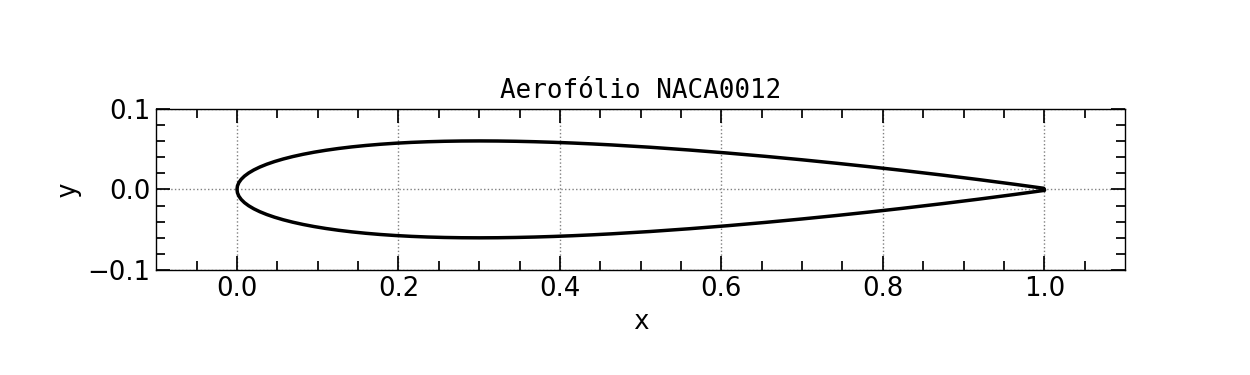

In [10]:
plt.figure(figsize = (10, 3))

plt.plot(x, y, color = 'black', linestyle = '-', linewidth = 2)
plt.axis('scaled')

plt.title('Aerofólio NACA0012', family = 'monospace', fontsize = 15)
plt.xlabel('x', family = 'monospace', fontsize = 15)
plt.ylabel('y', family = 'monospace', fontsize = 15)
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.1)

opt_plot()

plt.savefig('Aerofólio NACA0012.png', dpi = 400)

### 4.1 Discretização em painéis

Como descrito na seção anterior, criaremos uma discretização da geometria do corpo em painéis (segmentos de linha em 2D). Os atributos de um painel são: seu ponto inicial, ponto final e ponto médio, seu comprimento e sua orientação. Veja a figura a seguir para a nomenclatura usada no código e nas equações abaixo.

![image](https://media.giphy.com/media/WuZMoChIzvH973No4D/giphy.gif)

Podemos modificar um pouco a classe `Panel` definida anteriormente, para funcionar melhor em nosso estudo de escoamento sobre um aerofólio. A única diferença é que identificamos pontos nas superfícies superior ou inferior com as palavras `upper` e `lower`, que só são usadas posteriormente para plotar resultados com cores diferentes para as superfícies superior e inferior do perfil.

In [11]:
class Panel:
    """
    Contém informações relativas ao painél
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Inicializa o painél
        
        - Define os pontos finais e calcula o centro, comprimento, 
        e o ângulo (com o eixo x) do painel. 
        
        - Define se o painel está na superfície inferior ou superior
        da geometria.
        
        - Inicializa a resistência da folha de origem, velocidade tangencial, 
        e coeficiente de pressão para zero.
        
        
        Parâmetros
        ----------
        xa: float
            Coordenada x do primeiro ponto final.
        ya: float
            Coordenada y do primeiro ponto final.
        xb: float
            Coordenada x do segundo ponto final.
        yb: float
            Coordenada y do segundo ponto final.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2  
        self.length = np.sqrt((xb - xa)**2 + (yb - ya)**2)  
        
        # Orientação do painél (ângulo entre o eixo x e a normal ao painél)
        if xb - xa <= 0.0:
            self.beta = np.arccos((yb - ya) / self.length)
        elif xb - xa > 0.0:
            self.beta = np.pi + np.arccos(-(yb - ya) / self.length)
        
        # Localização do painél
        if self.beta <= np.pi:
            self.loc = 'upper'
        else:
            self.loc = 'lower'
        
        self.sigma = 0.0  
        self.vt = 0.0  
        self.cp = 0.0  

Para o cilindro circular, a discretização em painéis foi muito fácil. Esta é a parte que fica mais complicada quando você deseja calcular o fluxo em torno de uma geometria geral, enquanto a parte da solução é efetivamente a mesma da seção anterior.

A função abaixo irá criar os painéis a partir dos dados de geometria que foram lidos de um arquivo. É melhor ter painéis pequenos perto da borda de ataque e da borda de fuga, onde a curvatura é grande. Um método para obter uma distribuição não uniforme ao redor do aerofólio é primeiro discretizar um círculo com diâmetro igual à corda do aerofólio, com o bordo de ataque e o bordo de fuga tocando o círculo em um nó, conforme mostrado no esboço a seguir.